 # Fruit Ripeness Detection

### Importing required libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount("/content/Mydrive")

TRAIN_PATH = "/content/Mydrive/MyDrive/dataset/Equal_dataset/train"
VAL_PATH = "/content/Mydrive/MyDrive/dataset/Equal_dataset/val"
TEST_PATH = "/content/Mydrive/MyDrive/dataset/Equal_dataset/test"

Mounted at /content/Mydrive


### Initializing Image Size

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

### Initializing train, validation & test data

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                   target_size=(IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 4840 images belonging to 3 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(VAL_PATH,
                                                             target_size=(IMAGE_SIZE),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 660 images belonging to 3 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Over Ripe
1 : Ripe
2 : Unripe


### Plot Images with labels

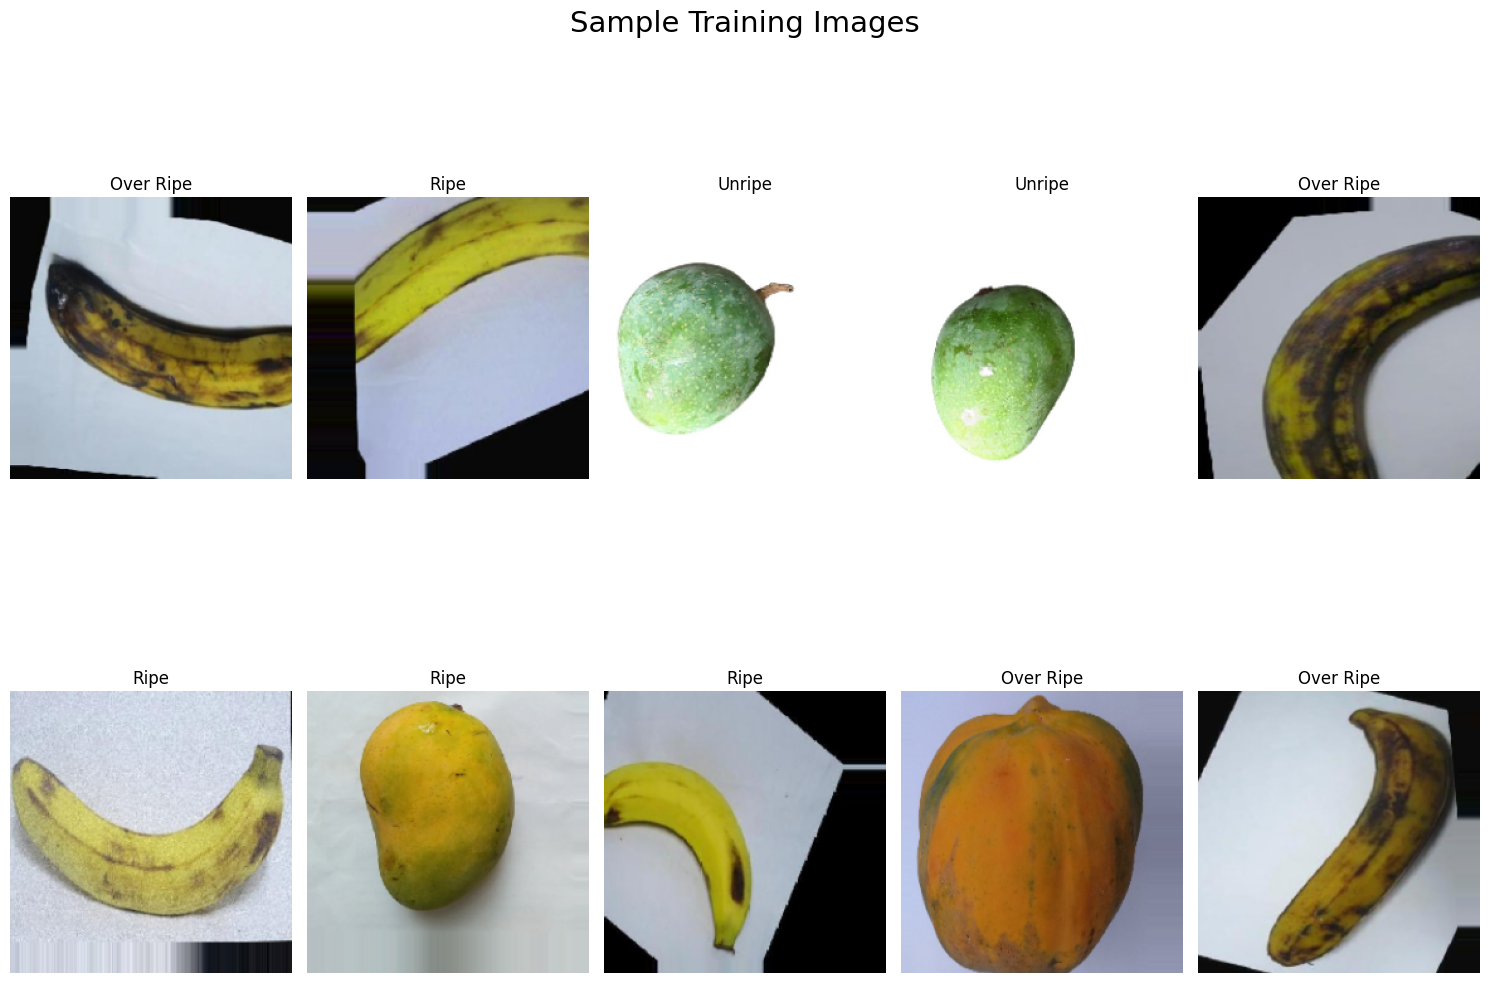

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [ ]:
class_num = 3
image_w = 224
image_h = 224

### Import model for Transfer Learning

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

inputs = layers.Input(shape=(image_w,image_h, 3))

outputs = VGG16(include_top=True, weights=None, classes=class_num)(inputs)

In [ ]:
# model = tf.keras.Model(inputs, outputs)

# model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"] )

# Define your model architecture
model = tf.keras.Model(inputs, outputs)

# Compile the model using the Adam optimizer from tf.keras.optimizers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 3)                 134272835 
                                                                 
Total params: 134272835 (512.21 MB)
Trainable params: 134272835 (512.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def learning_rate_schedule(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(learning_rate_schedule)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

### Train the model

In [ ]:
hist = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=2, callbacks = [lr_scheduler,early_stopping])

Epoch 1/50
152/152 - 1482s - loss: 1.1484 - accuracy: 0.3568 - val_loss: 1.0991 - val_accuracy: 0.3333 - lr: 0.0010 - 1482s/epoch - 10s/step
Epoch 2/50
152/152 - 106s - loss: 1.0971 - accuracy: 0.3636 - val_loss: 1.1027 - val_accuracy: 0.3333 - lr: 0.0010 - 106s/epoch - 697ms/step
Epoch 3/50
152/152 - 107s - loss: 1.0970 - accuracy: 0.3636 - val_loss: 1.0991 - val_accuracy: 0.3333 - lr: 0.0010 - 107s/epoch - 703ms/step
Epoch 4/50
152/152 - 106s - loss: 1.0971 - accuracy: 0.3636 - val_loss: 1.0997 - val_accuracy: 0.3333 - lr: 9.0484e-04 - 106s/epoch - 695ms/step
Epoch 5/50
152/152 - 106s - loss: 1.0970 - accuracy: 0.3636 - val_loss: 1.0999 - val_accuracy: 0.3333 - lr: 8.1873e-04 - 106s/epoch - 696ms/step
Epoch 6/50
152/152 - 107s - loss: 1.0969 - accuracy: 0.3636 - val_loss: 1.1009 - val_accuracy: 0.3333 - lr: 7.4082e-04 - 107s/epoch - 706ms/step
Epoch 7/50
152/152 - 104s - loss: 1.0970 - accuracy: 0.3636 - val_loss: 1.1005 - val_accuracy: 0.3333 - lr: 6.7032e-04 - 104s/epoch - 683ms/st

### Train, Validation & Test accuracy from saved model

In [ ]:
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

learning_rate = hist.history['lr']



### Plot Accuracy & Loss graphs

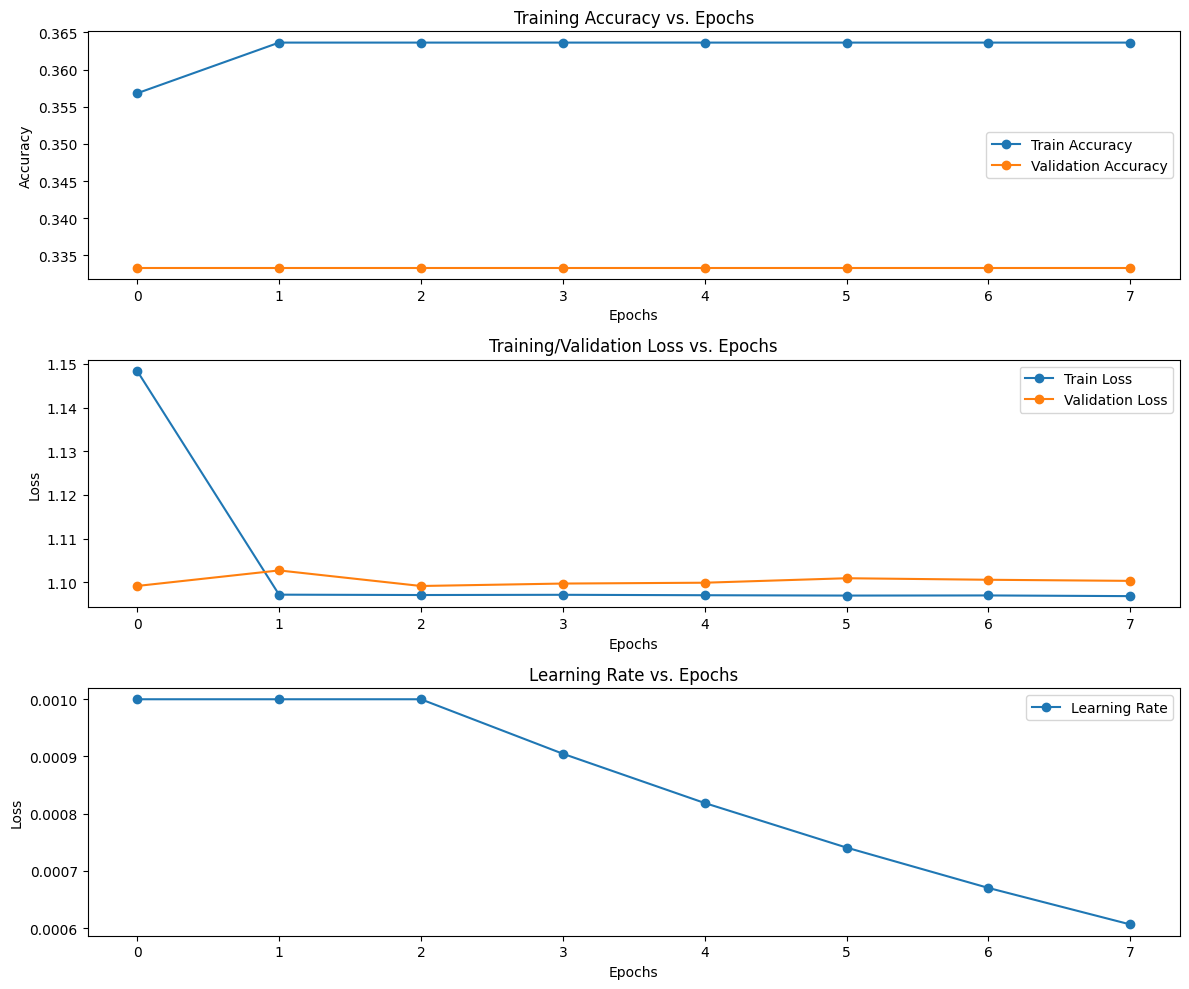

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

### Predictions on Test data

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMAGE_SIZE),
                                                 class_mode='categorical')


Found 1320 images belonging to 3 classes.


In [ ]:


predictions = model.predict(test_generator)

42/42 [==============================] - 314s 8s/step


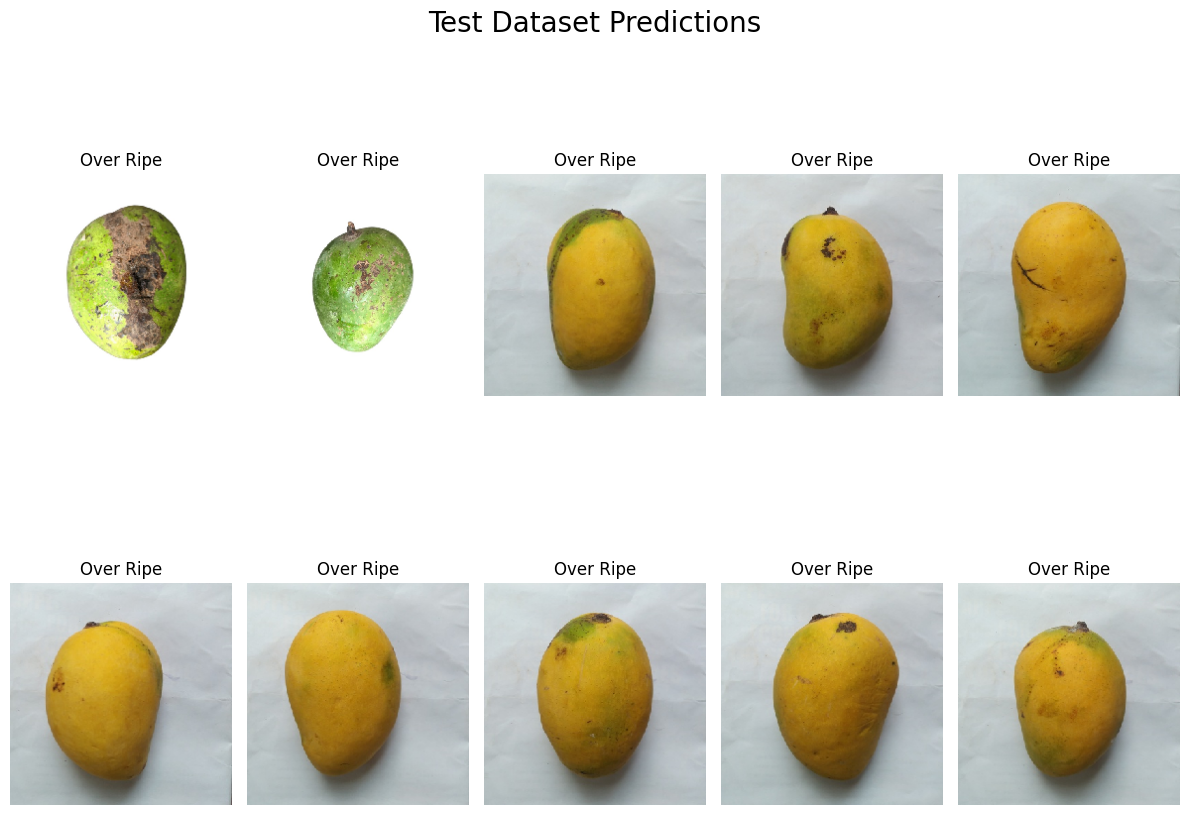

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

### F1- Score, Precision & Recall

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

42/42 [==============================] - 8s 182ms/step - loss: 1.0991 - accuracy: 0.3333


### Confusion Matrix

In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     1.0991181135177612
Test Accuracy: 0.3333333432674408


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

[[440   0   0]
 [440   0   0]
 [440   0   0]]


<Axes: >

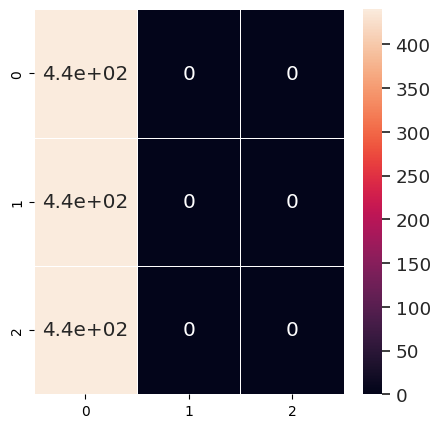

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm)
fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   Over Ripe       0.33      1.00      0.50       440
        Ripe       0.00      0.00      0.00       440
      Unripe       0.00      0.00      0.00       440

    accuracy                           0.33      1320
   macro avg       0.11      0.33      0.17      1320
weighted avg       0.11      0.33      0.17      1320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

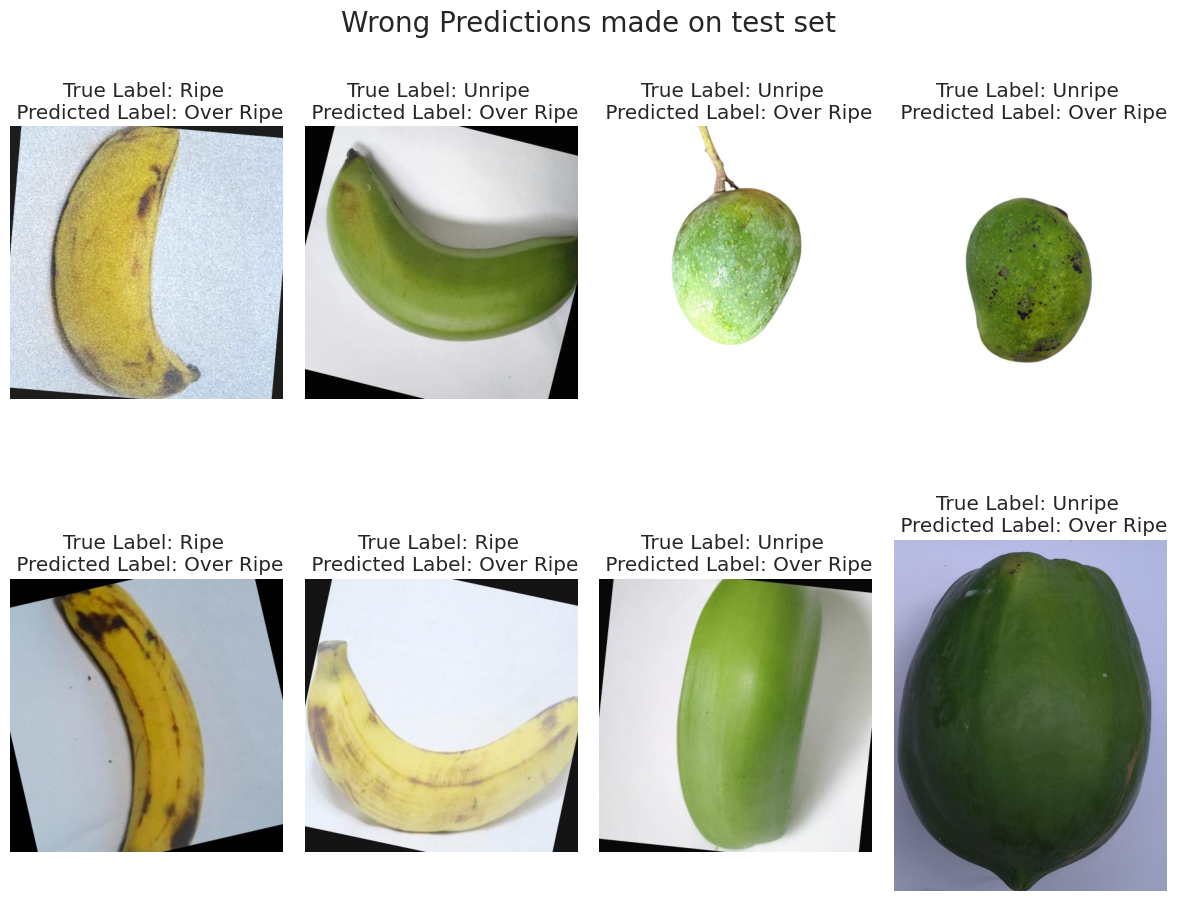

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(TEST_PATH, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [ ]:
tf.keras.models.save_model(model, "/content/Mydrive/MyDrive/VGG16.keras")